# Setup

In [129]:
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import numpy as np
from fastai.vision.all import *

In [130]:
DATA = Path('../../data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'
AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'

In [131]:
AUDIO_TAGGING.ls()

(#6) [Path('../../data/freesound-audio-tagging/test_post_competition.csv'),Path('../../data/freesound-audio-tagging/sample_submission.csv'),Path('../../data/freesound-audio-tagging/train.csv'),Path('../../data/freesound-audio-tagging/train_post_competition.csv'),Path('../../data/freesound-audio-tagging/audio_test'),Path('../../data/freesound-audio-tagging/audio_train')]

# Loading data

In [132]:
df = pd.read_csv(AUDIO_TAGGING/'train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [133]:
label = df.loc[df['fname'].eq("00044347.wav"), 'label'].iloc[0]

In [134]:
label

'Hi-hat'

In [135]:
df.shape

(9473, 3)

In [183]:
labels = df.label.unique()
print(labels)
print(len(labels))
print(df["label"].value_counts())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']
41
Hi-hat                   300
Laughter                 300
Shatter                  300
Applause                 300
Squeak                   300
Acoustic_guitar          300
Bass_drum                300
Saxophone                300
Flute                    300
Double_bass              300
Tearing                  300
Fart                     300
Clarinet                 300
Fireworks                300
Trumpet                  300
Violin_or_fiddle         300
Cello                  

In [137]:
path = AUDIO_TAGGING/'audio_train'

In [138]:
path.ls()

(#9473) [Path('../../data/freesound-audio-tagging/audio_train/2a871432.wav'),Path('../../data/freesound-audio-tagging/audio_train/704d6fc7.wav'),Path('../../data/freesound-audio-tagging/audio_train/f5729f4f.wav'),Path('../../data/freesound-audio-tagging/audio_train/84d0e459.wav'),Path('../../data/freesound-audio-tagging/audio_train/0b3c0588.wav'),Path('../../data/freesound-audio-tagging/audio_train/56a59a85.wav'),Path('../../data/freesound-audio-tagging/audio_train/f8742dce.wav'),Path('../../data/freesound-audio-tagging/audio_train/1f4a7bfe.wav'),Path('../../data/freesound-audio-tagging/audio_train/151b80e7.wav'),Path('../../data/freesound-audio-tagging/audio_train/c3015f33.wav')...]

# Exploring the data

In [139]:
from IPython.display import Audio

In [140]:
fnames = os.listdir(str(path))
len(fnames), fnames[:5]

(9473,
 ['2a871432.wav',
  '704d6fc7.wav',
  'f5729f4f.wav',
  '84d0e459.wav',
  '0b3c0588.wav'])

In [141]:
fn = fnames[5]
label = df.loc[df['fname'].eq(fn), 'label'].iloc[0]
print(label)
audio = str(path/fn)
Audio(str(path/fn))

Fart


In [142]:
data, sample_rate = librosa.load(audio)

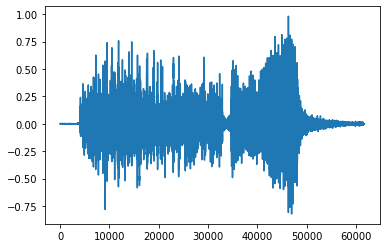

In [143]:
plt.plot(data)

In [144]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    data, sample_rate = librosa.load(src_path/fname)
    
    n_fft = 1024
    hop_length = 512
    n_mels = 80
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    
    #mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate)
    
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    
    label = df.loc[df['fname'].eq(fname), 'label'].iloc[0]
    
    dst_path = dst_path / label
    dst_path.mkdir(exist_ok=True)
    
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

In [145]:
dst_path = DATA/'free-sound/train'
dst_path.ls()

(#41) [Path('../../data/free-sound/train/Saxophone'),Path('../../data/free-sound/train/Cello'),Path('../../data/free-sound/train/Meow'),Path('../../data/free-sound/train/Bus'),Path('../../data/free-sound/train/Laughter'),Path('../../data/free-sound/train/Chime'),Path('../../data/free-sound/train/Bark'),Path('../../data/free-sound/train/Burping_or_eructation'),Path('../../data/free-sound/train/Bass_drum'),Path('../../data/free-sound/train/Harmonica')...]

In [146]:
def conv_spectogram(path):
    count = 0
    total = len(path.ls())
    for file in os.listdir(path):
        if (count % 100 == 0):
            print(f'{count}/{total}')
        #print(os.fsdecode(file))
        log_spec(os.fsdecode(file), path, dst_path) 
        count += 1

In [147]:
if not os.path.exists(dst_path):
    conv_spectogram(AUDIO_RECORDINGS)

In [148]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [149]:
#dls.show_batch()

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [150]:
dls = dblock.dataloaders(dst_path)

In [151]:
dls.one_batch()

(TensorImage([[[[0.2784, 0.2784, 0.2824,  ..., 0.2784, 0.2824, 0.2824],
           [0.2784, 0.2784, 0.2745,  ..., 0.2784, 0.2824, 0.2824],
           [0.2784, 0.2745, 0.2667,  ..., 0.2784, 0.2784, 0.2784],
           ...,
           [0.2667, 0.2667, 0.2667,  ..., 0.2784, 0.2784, 0.2784],
           [0.2667, 0.2667, 0.2667,  ..., 0.2706, 0.2745, 0.2745],
           [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2706, 0.2706]],
 
          [[0.1569, 0.1451, 0.1373,  ..., 0.1569, 0.1412, 0.1255],
           [0.1529, 0.1608, 0.1725,  ..., 0.1569, 0.1255, 0.0980],
           [0.1529, 0.1843, 0.2196,  ..., 0.1490, 0.1020, 0.0588],
           ...,
           [0.0039, 0.0039, 0.0039,  ..., 0.1686, 0.1725, 0.1725],
           [0.0039, 0.0039, 0.0039,  ..., 0.0784, 0.0824, 0.0863],
           [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0196]],
 
          [[0.4706, 0.4627, 0.4510,  ..., 0.4706, 0.4549, 0.4431],
           [0.4667, 0.4706, 0.4745,  ..., 0.4706, 0.4431, 0.4157],
           [0.4667,

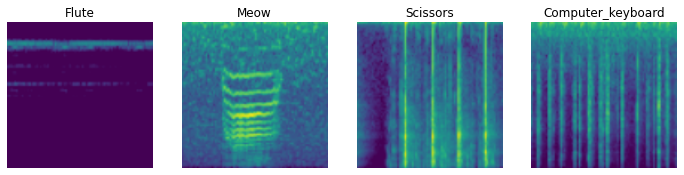

In [152]:
dls.valid.show_batch(max_n=4, nrows=1)

# Learning a model

In [163]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

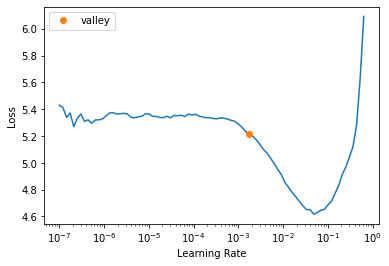

In [164]:
lr = learn.lr_find()

In [165]:
lrate = lr.valley

In [166]:
learn.fine_tune(8, lrate)

epoch,train_loss,valid_loss,error_rate,time
0,3.663147,2.260845,0.600317,00:07


epoch,train_loss,valid_loss,error_rate,time
0,2.524342,1.765715,0.482049,00:10
1,2.027091,1.508293,0.408659,00:10
2,1.677349,1.324893,0.362196,00:10
3,1.369308,1.164841,0.322598,00:10
4,1.146569,1.104697,0.304646,00:10
5,0.973517,1.053998,0.284055,00:10
6,0.837505,0.994138,0.271911,00:10
7,0.751197,0.995773,0.274551,00:10


In [167]:
interp = Interpretation.from_learner(learn)

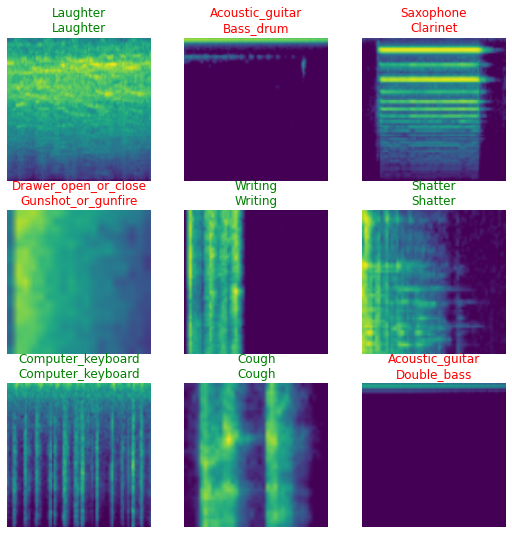

In [168]:
learn.show_results()

In [169]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs, nrows=8, )
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)



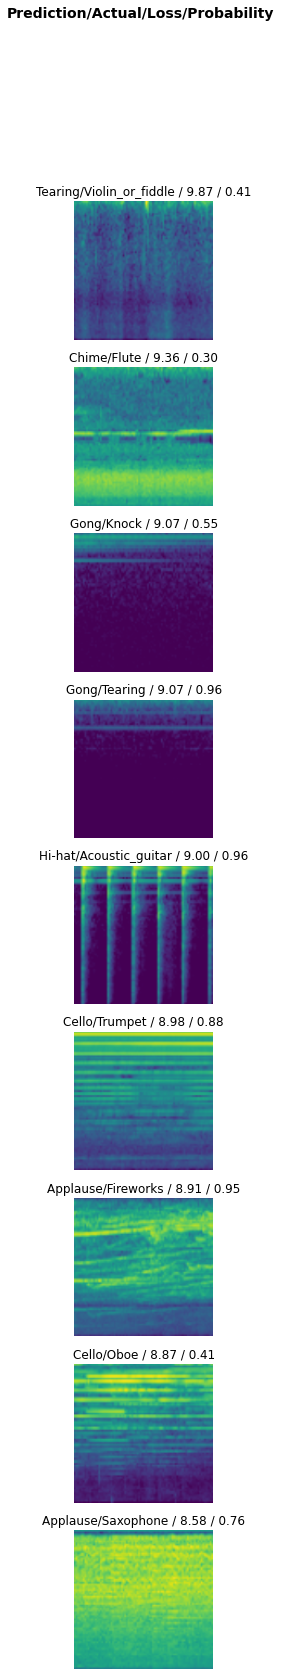

In [170]:
interp.plot_top_losses(9,nrows=9)
#plot_top_losses_fix(interp, k=8)

In [171]:
a = ClassificationInterpretation.from_learner(learn)

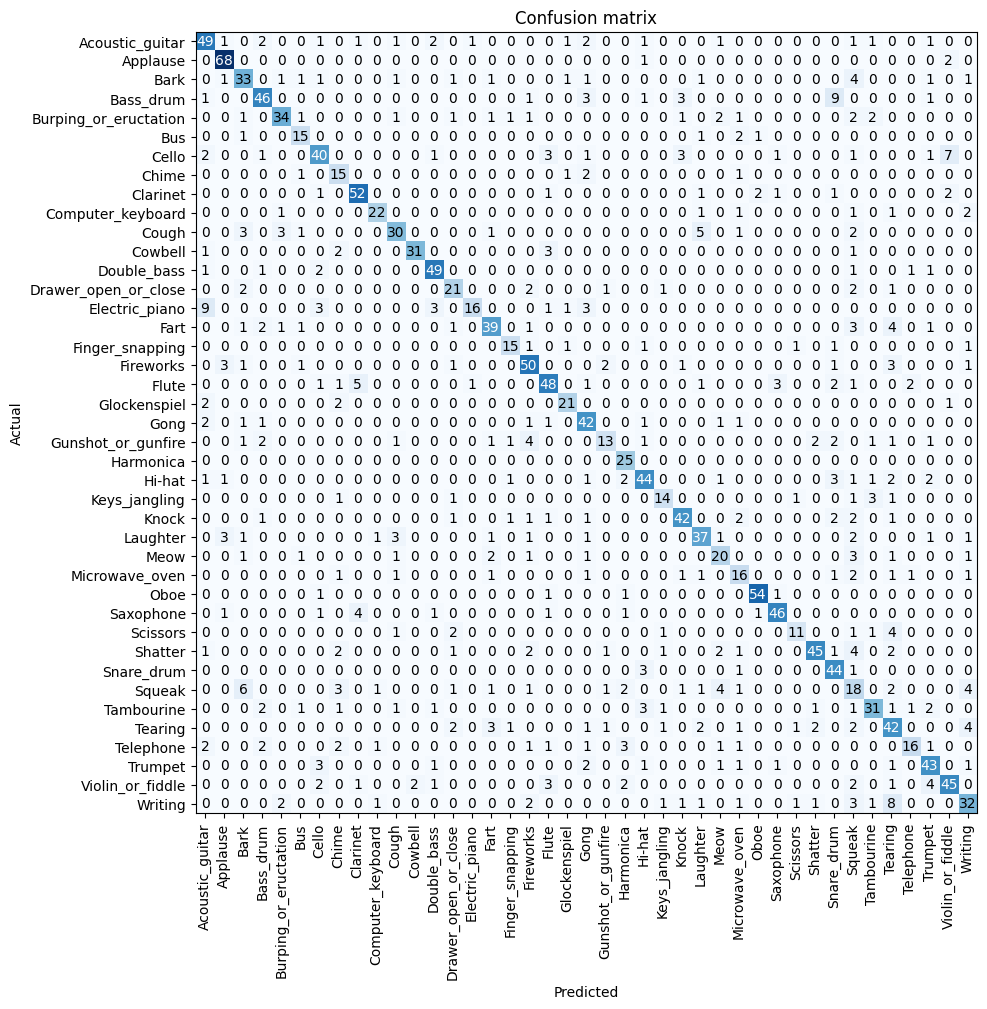

In [172]:
#plt.figure(figsize=(1000,1000))
a.plot_confusion_matrix(figsize=(10,10), dpi = 100)

# Evaluation

